# Implement LGBM Forecasting Model

***

This code implements an LGBM forecasting model. We use `sktime` to aid in managing the data, plotting, and setting up a forecasting pipeline.

***

Documentation for working with data in `sktime` can be found [here](https://www.sktime.org/en/stable/examples/loading_data.html).

Nested pandas DataFrames are used to store data in `sktime`. Rows correspond to instances, columns correspond to features. The values for each time period for a given feature are nested within a dataframe cell, e.g.:

| index |   dim_0   |    ...    |  dim_c-1  |
|:-----:|:---------:|:---------:|:---------:|
|   0   | pd.Series | pd.Series | pd.Series |
|  ...  | pd.Series | pd.Series | pd.Series |
|   n   | pd.Series | pd.Series | pd.Series |

A `pd.Series` is the one-dimensional data structure for `pandas`.

For univariate series, this structure becomes:

| index |   dim_0   |
|:-----:|:---------:|
|   0   | pd.Series |
|  ...  | pd.Series |
|   n   | pd.Series |

***

## Importing and Transforming Data

In [1]:
# import functions for transforming data to work with sktime
from sktime.datatypes._panel._convert import from_2d_array_to_nested, from_nested_to_2d_array, is_nested_dataframe
import pandas as pd

In [2]:
# import weekly finance time series
Y = pd.read_csv("../../../Data/Train/Clean/weekly_finance_clean.csv")

In [3]:
# store the number of series and number of time periods
num_series, num_periods = Y.shape

In [4]:
Y

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248
0,10825.88,10830.99,10831.68,10826.93,10782.88,10753.11,10708.7,10133.12,10055.67,9976.13,...,10551.34,10536.37,10603.52,10625.25,10665.82,10647.36,10642.22,10678.92,10678.0,10676.48
1,1725.70,1725.70,1749.70,1749.70,1917.60,1917.60,1813.3,1813.30,1991.30,1991.30,...,3538.90,3611.90,3611.90,3680.90,3680.90,3534.20,3534.20,3566.90,3566.9,3489.80
2,733.60,856.20,778.30,763.20,744.50,745.70,681.4,668.70,695.10,729.70,...,1043.80,1081.10,1081.40,1089.10,984.80,1048.60,1059.60,1113.30,1016.8,1084.10
3,733.60,856.20,778.30,763.20,744.50,745.70,681.4,668.70,695.10,729.70,...,1043.80,1081.10,1081.40,1089.10,984.80,1048.60,1059.60,1113.30,1016.8,1084.10
4,2166.00,2126.00,2100.00,2026.00,2028.00,2015.00,2013.0,1983.00,2019.00,2036.00,...,2536.00,2534.00,2554.00,2567.00,2548.00,2512.00,2542.00,2606.00,2607.0,2530.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,1092.00,1085.00,1078.00,1092.00,1085.00,1078.00,1092.0,1086.00,1078.00,1091.00,...,1093.00,1085.00,1078.00,1071.00,1064.00,1092.00,1085.00,1078.00,1071.0,1064.00
160,1820.00,1813.00,1806.00,1799.00,1792.00,1820.00,1813.0,1806.00,1799.00,1820.00,...,1799.00,1792.00,1785.00,1820.00,1813.00,1806.00,1799.00,1792.00,1785.0,1778.00
161,1917.90,1918.30,1947.70,1954.50,2022.70,2008.30,1996.6,1984.30,1978.80,1980.40,...,2578.70,2588.40,2573.90,2579.90,2564.10,2584.90,2503.20,2378.30,2381.2,2509.40
162,1368.00,1305.50,1308.60,1280.20,1356.30,1217.90,1432.5,1256.30,1363.80,1480.10,...,2232.70,2278.50,2255.70,2166.70,2127.70,2112.70,2102.90,2102.20,2177.5,2160.30


In [5]:
# transform to nested dataframe structure
Y_nested = from_2d_array_to_nested(Y)

In [6]:
# test for nested dataframe structure
is_nested_dataframe(Y_nested)

True

In [7]:
Y_nested

,0
0,0 10825.88 1 10830.99 2 10831.6...
1,0 1725.7 1 1725.7 2 1749.7 3 ...
2,0 733.6 1 856.2 2 778.3 3 ...
3,0 733.6 1 856.2 2 778.3 3 ...
4,0 2166.0 1 2126.0 2 2100.0 3 ...
...,...
159,0 1092.0 1 1085.0 2 1078.0 3 ...
160,0 1820.0 1 1813.0 2 1806.0 3 ...
161,0 1917.9 1 1918.3 2 1947.7 3 ...
162,0 1368.0 1 1305.5 2 1308.6 3 ...


***

## Forecast with Local LGBM for One Series

First, train a local LGBM model (trained on data from one series) for one series only.

In [8]:
# general modules
import pandas as pd
import numpy as np

# light gradient boosting model package
import lightgbm as lgb

#### sktime functions ####

# train-test split function for temporal data
from sktime.forecasting.model_selection import temporal_train_test_split

# import trend forecaster to detrend data
from sktime.forecasting.trend import PolynomialTrendForecaster

# import detrender and deseasonalizer
from sktime.transformations.series.detrend import Detrender, Deseasonalizer

# data reduction for regressions or trees
from sktime.forecasting.compose import make_reduction

# import composite forecasting tool
from sktime.forecasting.compose import TransformedTargetForecaster

# import mean absolute error and mean squared error metrics (specify square root in function)
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

# nice time series plots
from sktime.utils.plotting import plot_series

In [9]:
# forecast 20 periods out
fh = np.arange(1, 21)

Scikit-learn API for regression using lgbm [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor).

In [10]:
# this function has tons of options to mess with, we use defaults here
regressor = lgb.LGBMRegressor()

In [11]:
#### forecasting pipeline
# deseasonalize the data
# detrend the data
# ------- need to make these conditional transformations

forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(sp=52, model="additive")),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", make_reduction(regressor, window_length=6, strategy="recursive")),
    ]
)

In [12]:
# select one series
y = Y_nested.iloc[3,0]
y

0       733.6
1       856.2
2       778.3
3       763.2
4       744.5
        ...  
242    1048.6
243    1059.6
244    1113.3
245    1016.8
246    1084.1
Length: 247, dtype: float64

In [13]:
# train - test split
y_train, y_test = temporal_train_test_split(y, test_size=len(fh))

In [14]:
# train the forecasting model
forecaster.fit(y_train)

TransformedTargetForecaster(steps=[('deseasonalize', Deseasonalizer(sp=52)),
                                   ('detrend',
                                    Detrender(forecaster=PolynomialTrendForecaster())),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(),
                                                                         window_length=6))])

In [15]:
# generate forecasts
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

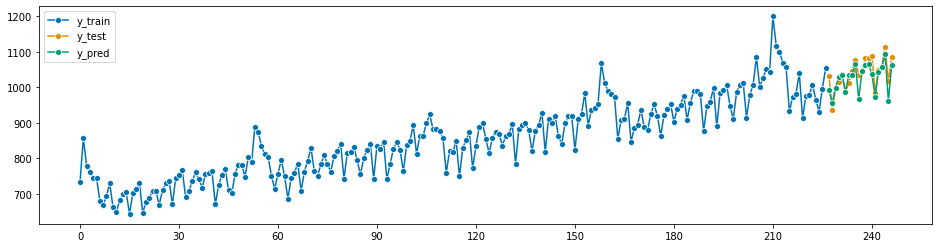

In [16]:
# plot training and testing data and forecasts (y_pred)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

In [17]:
# MAE
mean_absolute_error(y_test, y_pred)

19.75214133364893

In [18]:
# RMSE
mean_squared_error(y_test, y_pred, square_root=True)

27.251539173688666

***

## Forecast with Local LGBM for All Series

In [19]:
# empty arrays to store error metrics for each series
maes = np.zeros([num_series])
rmses = np.zeros([num_series])
# list to store forecasts
Y_preds = []

# loop over all series
for i in range(num_series):
    # select ith series
    y = Y_nested.iloc[i,0]
    
    # train-test split
    y_train, y_test = temporal_train_test_split(y, test_size=len(fh))
    
    # train model
    forecaster.fit(y_train)
    
    # generate forecasts
    y_pred = forecaster.predict(fh)
    
    # store forecasts
    Y_preds.append(y_pred)
    
    # store error metrics
    maes[i] = mean_absolute_error(y_test, y_pred)
    rmses[i] = mean_squared_error(y_test, y_pred, square_root=True)    

In [20]:
# average mean absolute error across series
np.mean(maes)

141.0380413352515

In [21]:
# average root mean squared error across series
np.mean(rmses)

164.84702469187312

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

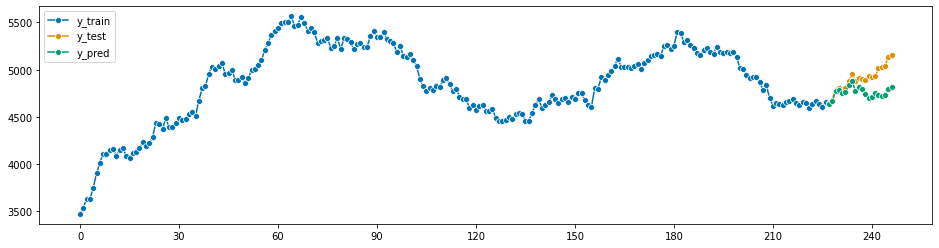

In [22]:
series_num = 50
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

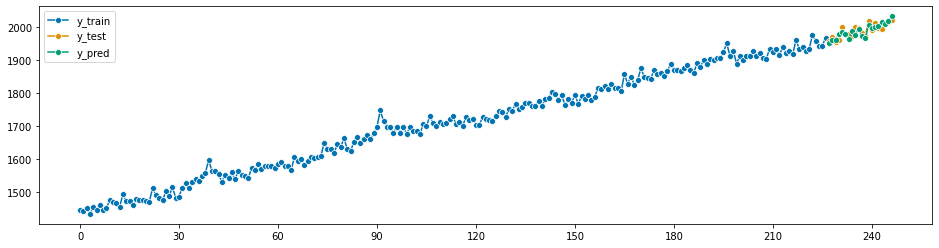

In [23]:
series_num = 100
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

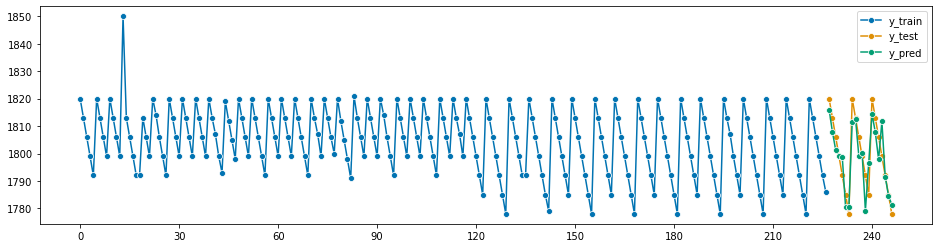

In [24]:
series_num = 160
plot_series(Y_nested.iloc[series_num,0][:-len(fh)],
            Y_nested.iloc[series_num,0][-len(fh):],
            Y_preds[series_num], 
            labels=["y_train", "y_test", "y_pred"])

***

## Forecast with Global LGBM for All Series